In [1]:
%matplotlib inline


# Matching Image Keypoints by Graph Matching Neural Networks

This example shows how to match image keypoints by neural network-based graph matching solvers.
These graph matching solvers are designed to match two individual graphs. The matched images
can be further passed to tackle downstream tasks.


In [2]:
# Author: Runzhong Wang <runzhong.wang@sjtu.edu.cn>
#         Wenzheng Pan <pwz1121@sjtu.edu.cn>
#
# License: Mulan PSL v2 License

<div class="alert alert-info"><h4>Note</h4><p>The following solvers are based on matching two individual graphs, and are included in this example:

    * :func:`~pygmtools.neural_solvers.pca_gm` (neural network solver)

    * :func:`~pygmtools.neural_solvers.ipca_gm` (neural network solver)

    * :func:`~pygmtools.neural_solvers.cie` (neural network solver)</p></div>




In [3]:
import jittor as jt # jittor backend
from jittor import Var, models, nn
import pygmtools as pygm
import matplotlib.pyplot as plt # for plotting
from matplotlib.patches import ConnectionPatch # for plotting matching result
import scipy.io as sio # for loading .mat file
import scipy.spatial as spa # for Delaunay triangulation
from sklearn.decomposition import PCA as PCAdimReduc
import itertools
import numpy as np
from PIL import Image
pygm.BACKEND = 'jittor' # set default backend for pygmtools
jt.flags.use_cuda = jt.has_cuda

[i 1220 00:07:29.732079 76 log.cc:351] Load log_sync: 1
[i 1220 00:07:29.770028 76 compiler.py:955] Jittor(1.3.4.20) src: /root/anaconda3/envs/jittor/lib/python3.7/site-packages/jittor
[i 1220 00:07:29.782831 76 compiler.py:956] g++ at /usr/bin/g++(9.4.0)
[i 1220 00:07:29.783675 76 compiler.py:957] cache_path: /root/.cache/jittor/jt1.3.4/g++9.4.0/py3.7.13/Linux-5.15.79.xa5/11thGenIntelRCx62/default
[i 1220 00:07:29.798849 76 __init__.py:411] Found /usr/local/cuda/bin/nvcc(11.1.105) at /usr/local/cuda/bin/nvcc.
[i 1220 00:07:30.021103 76 __init__.py:411] Found gdb(20.04.1) at /usr/bin/gdb.
[i 1220 00:07:30.042669 76 __init__.py:411] Found addr2line(2.34) at /usr/bin/addr2line.
[i 1220 00:07:30.185799 76 compiler.py:1010] cuda key:cu11.1.105
[i 1220 00:07:30.507933 76 __init__.py:227] Total mem: 29.38GB, using 9 procs for compiling.
[i 1220 00:07:33.435211 76 jit_compiler.cc:28] Load cc_path: /usr/bin/g++


Compiling jittor_core(147/147) used: 2.065s eta: 0.000s


[i 1220 00:07:33.982411 76 init.cc:62] Found cuda archs: [86,]
[i 1220 00:07:35.848560 76 __init__.py:411] Found mpicc(4.0.3) at /usr/bin/mpicc.
[i 1220 00:07:36.270634 76 compile_extern.py:30] found /usr/local/cuda/include/cublas.h
[i 1220 00:07:36.289716 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcublas.so
[i 1220 00:07:36.291023 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcublasLt.so.11
[i 1220 00:07:38.572802 76 compile_extern.py:30] found /usr/local/cuda/include/cudnn.h
[i 1220 00:07:38.652750 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcudnn.so.8
[i 1220 00:07:38.654756 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcudnn_ops_infer.so.8
[i 1220 00:07:38.672360 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcudnn_ops_train.so.8
[i 1220 00:07:38.678161 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcudnn_cnn_infer.so.8
[i 1220 00:07:38.937944 76 compile_extern.py:30] found /usr/local/cuda/lib64/libcudnn_cnn_train.so.8


## Predicting Matching by Graph Matching Neural Networks
In this section we show how to do predictions (inference) by graph matching neural networks.
Let's take PCA-GM (:func:`~pygmtools.neural_solvers.pca_gm`) as an example.

### Load the images
Images are from the Willow Object Class dataset (this dataset also available with the Benchmark of ``pygmtools``,
see :class:`~pygmtools.dataset.WillowObject`).

The images are resized to 256x256.




In [4]:
obj_resize = (256, 256)
img1 = Image.open('./data/willow_duck_0001.png')
img2 = Image.open('./data/willow_duck_0002.png')
kpts1 = jt.Var(sio.loadmat('./data/willow_duck_0001.mat')['pts_coord'])
kpts2 = jt.Var(sio.loadmat('./data/willow_duck_0002.mat')['pts_coord'])
kpts1[0] = kpts1[0] * obj_resize[0] / img1.size[0]
kpts1[1] = kpts1[1] * obj_resize[1] / img1.size[1]
kpts2[0] = kpts2[0] * obj_resize[0] / img2.size[0]
kpts2[1] = kpts2[1] * obj_resize[1] / img2.size[1]
img1 = img1.resize(obj_resize, resample=Image.BILINEAR)
img2 = img2.resize(obj_resize, resample=Image.BILINEAR)
jittor_img1 = jt.Var(np.array(img1, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW
jittor_img2 = jt.Var(np.array(img2, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW

/root/anaconda3/envs/jittor/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # Remove the CWD from sys.path while we load stuff.
/root/anaconda3/envs/jittor/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # This is added back by InteractiveShellApp.init_path()


Visualize the images and keypoints





Compiling Operators(4/4) used: 3.31s eta:    0s 


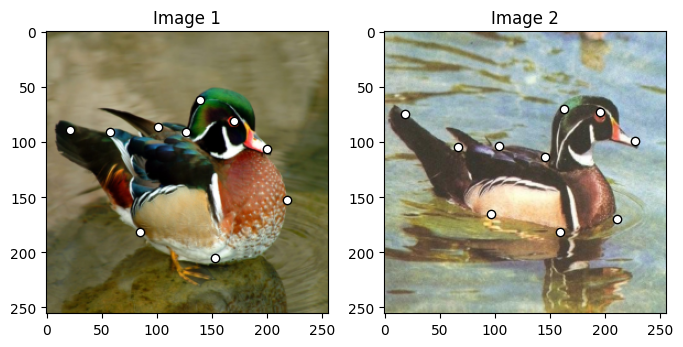

In [5]:
def plot_image_with_graph(img, kpt, A=None):
    plt.imshow(img)
    plt.scatter(kpt[0], kpt[1], c='w', edgecolors='k')
    if A is not None:
        for idx in jt.nonzero(A):
            plt.plot((kpt[0, idx[0]], kpt[0, idx[1]]), (kpt[1, idx[0]], kpt[1, idx[1]]), 'k-')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plot_image_with_graph(img1, kpts1)
plt.subplot(1, 2, 2)
plt.title('Image 2')
plot_image_with_graph(img2, kpts2)

### Build the graphs
Graph structures are built based on the geometric structure of the keypoint set. In this example,
we refer to [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation).




In [6]:
def delaunay_triangulation(kpt):
    d = spa.Delaunay(kpt.numpy().transpose())
    A = jt.zeros((len(kpt[0]), len(kpt[0])))
    for simplex in d.simplices:
        for pair in itertools.permutations(simplex, 2):
            A[pair] = 1
    return A

A1 = delaunay_triangulation(kpts1)
A2 = delaunay_triangulation(kpts2)

Visualize the graphs





Compiling Operators(5/5) used: 2.31s eta:    0s 

Compiling Operators(1/1) used: 3.83s eta:    0s 

Compiling Operators(4/4) used: 2.31s eta:    0s 
/root/anaconda3/envs/jittor/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'jittor_core.Var' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'jittor_core.Var', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/root/anaconda3/envs/jittor/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If

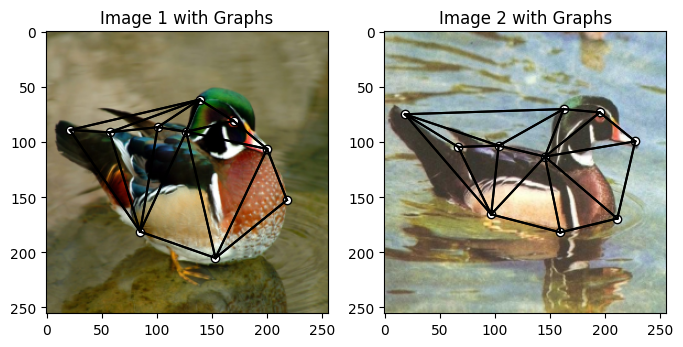

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1, A1)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Graphs')
plot_image_with_graph(img2, kpts2, A2)

### Extract node features via CNN
Deep graph matching solvers can be fused with CNN feature extractors, to build an end-to-end learning pipeline.

In this example, let's adopt the deep graph solvers based on matching two individual graphs.
The image features are based on two intermediate layers from the VGG16 CNN model, following
existing deep graph matching papers (such as :func:`~pygmtools.neural_solvers.pca_gm`)

Let's firstly fetch and download the VGG16 model:




In [8]:
vgg16_cnn = models.vgg16_bn(True)

List of layers of VGG16:




In [9]:
print(vgg16_cnn.features)

Sequential(
    0: Conv(3, 64, (3, 3), (1, 1), (1, 1), (1, 1), 1, float32[64,], None, Kw=None, fan=None, i=None, bound=None)
    1: BatchNorm(64, 1e-05, momentum=0.1, affine=True, is_train=True, sync=True)
    2: relu()
    3: Conv(64, 64, (3, 3), (1, 1), (1, 1), (1, 1), 1, float32[64,], None, Kw=None, fan=None, i=None, bound=None)
    4: BatchNorm(64, 1e-05, momentum=0.1, affine=True, is_train=True, sync=True)
    5: relu()
    6: Pool((2, 2), (2, 2), padding=(0, 0), dilation=None, return_indices=None, ceil_mode=False, count_include_pad=False, op=maximum)
    7: Conv(64, 128, (3, 3), (1, 1), (1, 1), (1, 1), 1, float32[128,], None, Kw=None, fan=None, i=None, bound=None)
    8: BatchNorm(128, 1e-05, momentum=0.1, affine=True, is_train=True, sync=True)
    9: relu()
    10: Conv(128, 128, (3, 3), (1, 1), (1, 1), (1, 1), 1, float32[128,], None, Kw=None, fan=None, i=None, bound=None)
    11: BatchNorm(128, 1e-05, momentum=0.1, affine=True, is_train=True, sync=True)
    12: relu()
    13: P

Let's define the CNN feature extractor, which outputs the features of ``layer (30)`` and
``layer (37)``




In [10]:
class CNNNet(jt.nn.Module):
    def __init__(self, vgg16_module):
        super(CNNNet, self).__init__()
        # The naming of the layers follow ThinkMatch convention to load pretrained models.
        self.node_layers = jt.nn.Sequential(*[_ for _ in list(vgg16_module.features)[:31]])
        self.edge_layers = jt.nn.Sequential(*[_ for _ in list(vgg16_module.features)[31:38]])

    def execute(self, inp_img):
        feat_local = self.node_layers(inp_img)
        feat_global = self.edge_layers(feat_local)
        return feat_local, feat_global

Download pretrained CNN weights (from [ThinkMatch](https://github.com/Thinklab-SJTU/ThinkMatch)),
load the weights and then extract the CNN features




In [11]:
cnn = CNNNet(vgg16_cnn)
path = pygm.utils.download('vgg16_pca_voc_jittor.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1qLxjcVq7X3brylxRJvELCbtCzfuXQ24J')
cnn.load_state_dict(jt.load(path))

with jt.no_grad():
    feat1_local, feat1_global = cnn(jittor_img1)
    feat2_local, feat2_global = cnn(jittor_img2)

[w 1220 00:08:07.144654 76 __init__.py:1344] load parameter gnn_layer_0.gconv.a_fc.weight failed ...
[w 1220 00:08:07.145741 76 __init__.py:1344] load parameter gnn_layer_0.gconv.a_fc.bias failed ...
[w 1220 00:08:07.146355 76 __init__.py:1344] load parameter gnn_layer_0.gconv.u_fc.weight failed ...
[w 1220 00:08:07.147722 76 __init__.py:1344] load parameter gnn_layer_0.gconv.u_fc.bias failed ...
[w 1220 00:08:07.148358 76 __init__.py:1344] load parameter affinity_0.A failed ...
[w 1220 00:08:07.149145 76 __init__.py:1344] load parameter cross_graph_0.weight failed ...
[w 1220 00:08:07.150480 76 __init__.py:1344] load parameter cross_graph_0.bias failed ...
[w 1220 00:08:07.151177 76 __init__.py:1344] load parameter gnn_layer_1.gconv.a_fc.weight failed ...
[w 1220 00:08:07.151858 76 __init__.py:1344] load parameter gnn_layer_1.gconv.a_fc.bias failed ...
[w 1220 00:08:07.153152 76 __init__.py:1344] load parameter gnn_layer_1.gconv.u_fc.weight failed ...
[w 1220 00:08:07.153787 76 __init

Normalize the features




In [12]:
def local_response_norm(input: Var, size: int, alpha: float = 1e-4, beta: float = 0.75, k: float = 1.0) -> Var:
    """
    jittor implementation of local_response_norm
    """
    dim = input.ndim
    assert dim >= 3

    if input.numel() == 0:
        return input

    div = input.multiply(input).unsqueeze(1)
    if dim == 3:
        div = nn.pad(div, (0, 0, size // 2, (size - 1) // 2))
        div = nn.avg_pool2d(div, (size, 1), stride=1).squeeze(1)
    else:
        sizes = input.size()
        div = div.view(sizes[0], 1, sizes[1], sizes[2], -1)
        div = nn.pad(div, (0, 0, 0, 0, size // 2, (size - 1) // 2))
        div = nn.AvgPool3d((size, 1, 1), stride=1)(div).squeeze(1)
        div = div.view(sizes)
    div = div.multiply(alpha).add(k).pow(beta)
    return input / div


def l2norm(node_feat):
    return local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [13]:
feat1_local_upsample = jt.nn.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = jt.nn.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = jt.nn.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = jt.nn.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = jt.concat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = jt.concat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Visualize the extracted CNN feature (dimensionality reduction via principle component analysis)





Compiling Operators(10/13) used: 5.31s eta: 1.59s 13/13) used: 8.32s eta:    0s 
/root/anaconda3/envs/jittor/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'jittor_core.Var' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'jittor_core.Var', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/root/anaconda3/envs/jittor/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

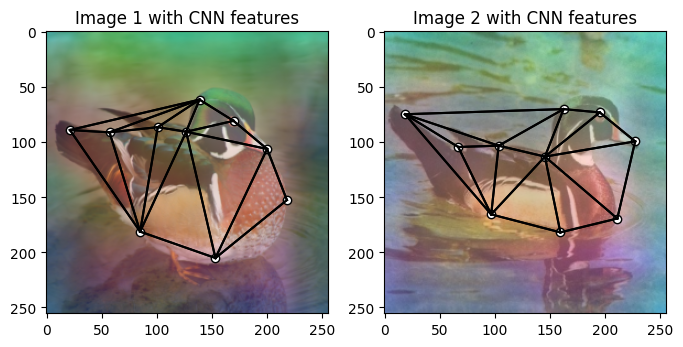

In [14]:
pca_dim_reduc = PCAdimReduc(n_components=3, whiten=True)
feat_dim_reduc = pca_dim_reduc.fit_transform(
    np.concatenate((
        feat1_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy(),
        feat2_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy()
    ), axis=0)
)
feat_dim_reduc = feat_dim_reduc / np.max(np.abs(feat_dim_reduc), axis=0, keepdims=True) / 2 + 0.5
feat1_dim_reduc = feat_dim_reduc[:obj_resize[0] * obj_resize[1], :]
feat2_dim_reduc = feat_dim_reduc[obj_resize[0] * obj_resize[1]:, :]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with CNN features')
plot_image_with_graph(img1, kpts1, A1)
plt.imshow(feat1_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)
plt.subplot(1, 2, 2)
plt.title('Image 2 with CNN features')
plot_image_with_graph(img2, kpts2, A2)
plt.imshow(feat2_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)

Extract node features by nearest interpolation




In [15]:
rounded_kpts1 = jt.round(kpts1).long()
rounded_kpts2 = jt.round(kpts2).long()
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

### Call PCA-GM matching model
See :func:`~pygmtools.neural_solvers.pca_gm` for the API reference.





Compiling Operators(4/5) used: 3.31s eta: 0.828s 5/5) used: 4.32s eta:    0s 

Compiling Operators(1/1) used:    3s eta:    0s 

Compiling Operators(1/10) used: 3.31s eta: 29.8s 6/10) used: 4.32s eta: 2.88s 7/10) used: 5.33s eta: 2.28s 8/10) used: 6.34s eta: 1.58s 10/10) used: 7.35s eta:    0s 

Compiling Operators(2/2) used: 3.31s eta:    0s 


transposed_batch: [False]



Compiling Operators(3/3) used: 3.31s eta:    0s 

Compiling Operators(1/1) used:  2.8s eta:    0s 

Compiling Operators(5/51) used: 3.31s eta: 30.5s 9/51) used: 4.32s eta: 20.2s 14/51) used: 8.34s eta:   22s 18/51) used: 9.35s eta: 17.1s 23/51) used: 12.4s eta:   15s 26/51) used: 13.4s eta: 12.9s 27/51) used: 14.4s eta: 12.8s 31/51) used: 16.4s eta: 10.6s 35/51) used: 17.4s eta: 7.96s 36/51) used: 18.4s eta: 7.67s 40/51) used: 20.4s eta: 5.62s 44/51) used: 21.4s eta: 3.41s 45/51) used: 22.5s eta: 2.99s 47/51) used: 23.5s eta:    2s 50/51) used: 24.5s eta: 0.489s 51/51) used: 25.5s eta:    0s 


transposed_batch: [False]



Compiling Operators(2/2) used: 3.31s eta:    0s 

Compiling Operators(1/1) used: 2.08s eta:    0s 


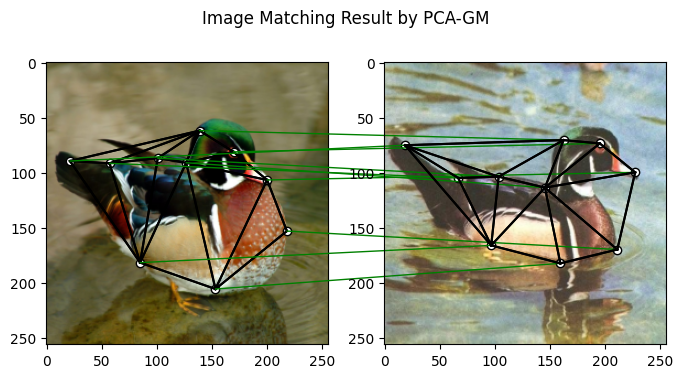

In [16]:
X = pygm.pca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by PCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
idx, _ = jt.argmax(X, dim=1)
for i in range(X.shape[0]):
    j = idx[i].item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

## Matching images with other neural networks
The above pipeline also works for other deep graph matching networks. Here we give examples of
:func:`~pygmtoools.neural_solvers.ipca_gm` and :func:`~pygmtoools.neural_solvers.cie`.

### Matching by IPCA-GM model
See :func:`~pygmtools.neural_solvers.ipca_gm` for the API reference.




In [17]:
path = pygm.utils.download('vgg16_ipca_voc_jittor.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1f7KEl9ZFZwI26j6UId-fsdl8Y8QWPKZi')
cnn.load_state_dict(jt.load(path))

feat1_local, feat1_global = cnn(jittor_img1)
feat2_local, feat2_global = cnn(jittor_img2)

[w 1220 00:09:36.221828 76 __init__.py:1344] load parameter gnn_layer_0.gconv.a_fc.weight failed ...
[w 1220 00:09:36.222500 76 __init__.py:1344] load parameter gnn_layer_0.gconv.a_fc.bias failed ...
[w 1220 00:09:36.223161 76 __init__.py:1344] load parameter gnn_layer_0.gconv.u_fc.weight failed ...
[w 1220 00:09:36.224156 76 __init__.py:1344] load parameter gnn_layer_0.gconv.u_fc.bias failed ...
[w 1220 00:09:36.224934 76 __init__.py:1344] load parameter affinity_0.A failed ...
[w 1220 00:09:36.225483 76 __init__.py:1344] load parameter cross_graph_0.weight failed ...
[w 1220 00:09:36.226160 76 __init__.py:1344] load parameter cross_graph_0.bias failed ...
[w 1220 00:09:36.226783 76 __init__.py:1344] load parameter gnn_layer_1.gconv.a_fc.weight failed ...
[w 1220 00:09:36.227333 76 __init__.py:1344] load parameter gnn_layer_1.gconv.a_fc.bias failed ...
[w 1220 00:09:36.228060 76 __init__.py:1344] load parameter gnn_layer_1.gconv.u_fc.weight failed ...
[w 1220 00:09:36.228655 76 __init

Normalize the features




In [18]:
def l2norm(node_feat):
    return local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [19]:
feat1_local_upsample = jt.nn.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = jt.nn.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = jt.nn.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = jt.nn.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = jt.concat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = jt.concat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Extract node features by nearest interpolation




In [20]:
rounded_kpts1 = jt.round(kpts1).long()
rounded_kpts2 = jt.round(kpts2).long()
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

Build edge features as edge lengths




In [21]:
kpts1_dis = (kpts1.unsqueeze(0) - kpts1.unsqueeze(1))
kpts1_dis = jt.norm(kpts1_dis, p=2, dim=2).detach()
kpts2_dis = (kpts2.unsqueeze(0) - kpts2.unsqueeze(1))
kpts2_dis = jt.norm(kpts2_dis, p=2, dim=2).detach()

Q1 = jt.exp(-kpts1_dis / obj_resize[0])
Q2 = jt.exp(-kpts2_dis / obj_resize[0])

Matching by IPCA-GM model





Compiling Operators(8/8) used: 4.31s eta:    0s 

Compiling Operators(1/1) used: 2.72s eta:    0s 


transposed_batch: [False]
transposed_batch: [False]
transposed_batch: [False]


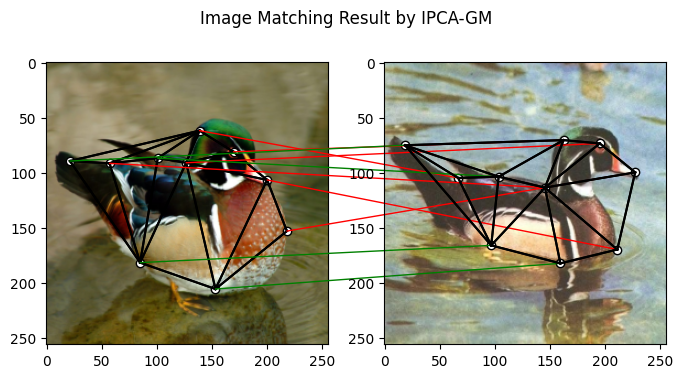

In [22]:
X = pygm.ipca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by IPCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
idx, _ = jt.argmax(X, dim=1)
for i in range(X.shape[0]):
    j = idx[i].item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

### Matching by CIE model
See :func:`~pygmtools.neural_solvers.cie` for the API reference.




In [23]:
path = pygm.utils.download('vgg16_cie_voc_jittor.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1wDbA-8sK4BNhA48z2c-Gtdd4AarRxfqT')
cnn.load_state_dict(jt.load(path))

feat1_local, feat1_global = cnn(jittor_img1)
feat2_local, feat2_global = cnn(jittor_img2)

[w 1220 00:09:48.666048 76 __init__.py:1344] load parameter gnn_layer_0.gconv.node_fc.weight failed ...
[w 1220 00:09:48.666734 76 __init__.py:1344] load parameter gnn_layer_0.gconv.node_fc.bias failed ...
[w 1220 00:09:48.667324 76 __init__.py:1344] load parameter gnn_layer_0.gconv.node_sfc.weight failed ...
[w 1220 00:09:48.668161 76 __init__.py:1344] load parameter gnn_layer_0.gconv.node_sfc.bias failed ...
[w 1220 00:09:48.668862 76 __init__.py:1344] load parameter gnn_layer_0.gconv.edge_fc.weight failed ...
[w 1220 00:09:48.669713 76 __init__.py:1344] load parameter gnn_layer_0.gconv.edge_fc.bias failed ...
[w 1220 00:09:48.670623 76 __init__.py:1344] load parameter affinity_0.A failed ...
[w 1220 00:09:48.671656 76 __init__.py:1344] load parameter cross_graph_0.weight failed ...
[w 1220 00:09:48.672384 76 __init__.py:1344] load parameter cross_graph_0.bias failed ...
[w 1220 00:09:48.673069 76 __init__.py:1344] load parameter cross_graph_edge_0.weight failed ...
[w 1220 00:09:48.

Normalize the features




In [24]:
def l2norm(node_feat):
    return local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

Up-sample the features to the original image size and concatenate




In [25]:
feat1_local_upsample = jt.nn.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = jt.nn.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = jt.nn.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = jt.nn.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = jt.concat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = jt.concat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

Extract node features by nearest interpolation




In [26]:
rounded_kpts1 = jt.round(kpts1).long()
rounded_kpts2 = jt.round(kpts2).long()
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

Build edge features as edge lengths




In [27]:
kpts1_dis = (kpts1.unsqueeze(1) - kpts1.unsqueeze(2))
kpts1_dis = jt.norm(kpts1_dis, p=2, dim=0).detach()
kpts2_dis = (kpts2.unsqueeze(1) - kpts2.unsqueeze(2))
kpts2_dis = jt.norm(kpts2_dis, p=2, dim=0).detach()

Q1 = jt.exp(-kpts1_dis / obj_resize[0]).unsqueeze(-1).float32()
Q2 = jt.exp(-kpts2_dis / obj_resize[0]).unsqueeze(-1).float32()

In [37]:
print(kpts1_dis.shape)
print(kpts1.shape)
print(kpts1.unsqueeze(1).shape)
print(kpts1.unsqueeze(2).shape)
print((kpts1.unsqueeze(1) - kpts1.unsqueeze(2)).shape)

[10,10,]
[2,10,]
[2,1,10,]
[2,10,1,]
[2,10,10,]


Call CIE matching model





Compiling Operators(4/4) used: 3.31s eta:    0s 

Compiling Operators(4/5) used: 3.31s eta: 0.828s 5/5) used: 3.32s eta:    0s 


transposed_batch: [False]
transposed_batch: [False]


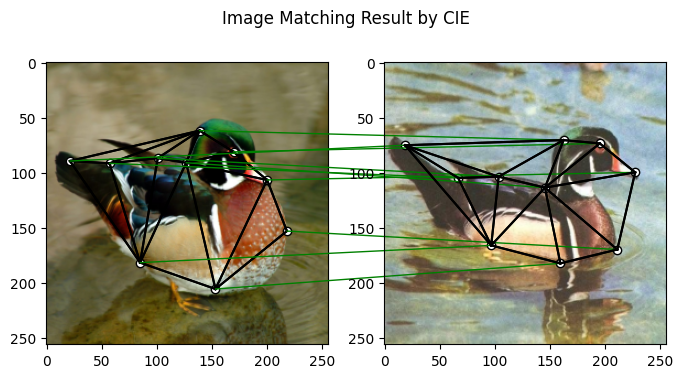

In [28]:
X = pygm.cie(node1, node2, A1, A2, Q1, Q2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by CIE')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
idx, _ = jt.argmax(X, dim=1)
for i in range(X.shape[0]):
    j = idx[i].item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

## Training a deep graph matching model
In this section, we show how to build a deep graph matching model which supports end-to-end training.
For the image matching problem considered here, the model is composed of a CNN feature extractor and
a learnable matching module. Take the PCA-GM model as an example.

<div class="alert alert-info"><h4>Note</h4><p>This simple example is intended to show you how to do the basic execute and backward pass when
    training an end-to-end deep graph matching neural network. A 'more formal' deep learning pipeline
    should involve asynchronized data loader, batched operations, CUDA support and so on, which are
    all omitted in consideration of simplicity. You may refer to [ThinkMatch](https://github.com/Thinklab-SJTU/ThinkMatch)
    which is a research protocol with all these advanced features.</p></div>

Let's firstly define the neural network model. By passing ``None`` to :func:`~pygmtools.neural_solvers.pca_gm`,
it will simply return the network object.




In [29]:
class GMNet(jt.nn.Module):
    def __init__(self):
        super(GMNet, self).__init__()
        self.gm_net = pygm.utils.get_network(pygm.pca_gm, pretrain=False) # fetch the network object
        self.cnn = CNNNet(vgg16_cnn)

    def execute(self, img1, img2, kpts1, kpts2, A1, A2):
        # CNN feature extractor layers
        feat1_local, feat1_global = self.cnn(img1)
        feat2_local, feat2_global = self.cnn(img2)
        feat1_local = l2norm(feat1_local)
        feat1_global = l2norm(feat1_global)
        feat2_local = l2norm(feat2_local)
        feat2_global = l2norm(feat2_global)

        # upsample feature map
        feat1_local_upsample = jt.nn.interpolate(feat1_local, obj_resize, mode='bilinear')
        feat1_global_upsample = jt.nn.interpolate(feat1_global, obj_resize, mode='bilinear')
        feat2_local_upsample = jt.nn.interpolate(feat2_local, obj_resize, mode='bilinear')
        feat2_global_upsample = jt.nn.interpolate(feat2_global, obj_resize, mode='bilinear')
        feat1_upsample = jt.concat((feat1_local_upsample, feat1_global_upsample), dim=1)
        feat2_upsample = jt.concat((feat2_local_upsample, feat2_global_upsample), dim=1)

        # assign node features
        rounded_kpts1 = jt.round(kpts1).long()
        rounded_kpts2 = jt.round(kpts2).long()
        node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t()  # shape: NxC
        node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t()  # shape: NxC

        # PCA-GM matching layers
        X = pygm.pca_gm(node1, node2, A1, A2, network=self.gm_net) # the network object is reused
        return X

model = GMNet()

### Define optimizer




In [30]:
optim = jt.optim.Adam(model.parameters(), lr=1e-3)

### Forward pass




In [31]:
X = model(jittor_img1, jittor_img2, kpts1, kpts2, A1, A2)

transposed_batch: [False]
transposed_batch: [False]


### Compute loss
In this example, the ground truth matching matrix is a diagonal matrix. We calculate the loss function via
:func:`~pygmtools.utils.permutation_loss`




In [32]:
X_gt = jt.init.eye(X.shape[0])
loss = pygm.utils.permutation_loss(X, X_gt)
print(f'loss={loss:.4f}')


Compiling Operators(2/2) used: 3.31s eta:    0s 

Compiling Operators(5/5) used: 3.31s eta:    0s 


loss=3.0008


### Backward Pass




In [33]:
optim.backward(loss)

Visualize the gradients





Compiling Operators(2/79) used: 4.31s eta:  166s 10/79) used: 5.33s eta: 36.8s 11/79) used: 8.34s eta: 51.6s 19/79) used: 9.36s eta: 29.5s 20/79) used: 12.4s eta: 36.5s 27/79) used: 13.4s eta: 25.8s 28/79) used: 14.4s eta: 26.2s 30/79) used: 17.4s eta: 28.4s 37/79) used: 18.4s eta: 20.9s 40/79) used: 21.4s eta: 20.9s 46/79) used: 22.4s eta: 16.1s 47/79) used: 24.4s eta: 16.6s 50/79) used: 25.5s eta: 14.8s 54/79) used: 26.5s eta: 12.3s 55/79) used: 27.5s eta:   12s 61/79) used: 29.5s eta:  8.7s 64/79) used: 30.5s eta: 7.15s 65/79) used: 32.5s eta:    7s 68/79) used: 33.5s eta: 5.42s 70/79) used: 34.5s eta: 4.44s 71/79) used: 35.5s eta:    4s 72/79) used: 36.6s eta: 3.55s 77/79) used: 37.6s eta: 0.976s 79/79) used: 38.6s eta:    0s 

Compiling Operators(1/1) used: 2.71s eta:    0s 

Compiling Operators(1/1) used: 2.69s eta:    0s 


[0.0001210035989060998, 0.0028971179854124784, 0.00017604572349227965, 0.0031971591524779797, 0.0002120720164384693, 0.005380360875278711, 1.4634986655437388e-05, 4.574530612444505e-05, 9.587767999619246e-05, 0.0037235580384731293, 0.00013242910790722817, 0.0030027462635189295, 0.00038530706660822034, 7.379070687818512e-09, 0.0008138595148921013, 0.0006219966453500092, 0.0, 0.0, 0.00015341967809945345, 3.983359864179192e-09, 0.0018974508857354522, 0.0010932802688330412, 0.0, 0.0, 0.00020903759286738932, 1.775254721003705e-09, 0.0014146137982606888, 0.0011990045895799994, 0.0, 0.0, 0.00018111581448465586, 1.6211321174353088e-09, 0.00154815090354532, 0.0009169140830636024, 0.0, 0.0, 0.00017409022257197648, 7.370372645532086e-10, 0.0015277082566171885, 0.001155440928414464, 0.0, 0.0, 0.00014879369700793177, 1.233302238112799e-09, 0.001601380412466824, 0.0012153685092926025, 0.0, 0.0, 0.0001636423694435507, 1.2234619983786388e-09, 0.001649069949053228, 0.0009254572214558721, 0.0, 0.0, 0.00

<StemContainer object of 3 artists>

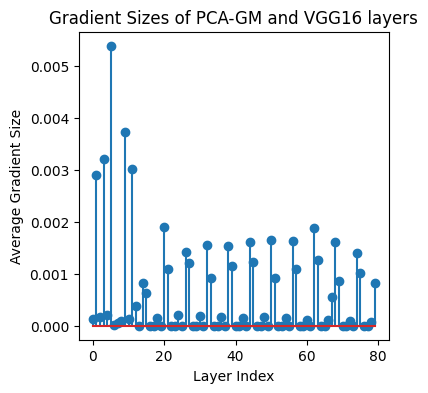

In [34]:
plt.figure(figsize=(4, 4))
plt.title('Gradient Sizes of PCA-GM and VGG16 layers')
plt.gca().set_xlabel('Layer Index')
plt.gca().set_ylabel('Average Gradient Size')
grad_size = []
for param in model.parameters():
    grad_size.append(jt.abs(param.opt_grad(optim)).mean().item())
print(grad_size)
plt.stem(grad_size)

Update the model parameters. A deep learning pipeline should iterate the forward pass
and backward pass steps until convergence.




In [35]:
optim.step()
optim.zero_grad()

<div class="alert alert-info"><h4>Note</h4><p>This example supports both GPU and CPU, and the online documentation is built by a CPU-only machine.
    The efficiency will be significantly improved if you run this code on GPU.</p></div>


